In [1]:
from train import train_epochs
from gan_sn import Generator, Discriminator
# from utils.utils import *
from utils.exp1 import experiment_save_results, visualize_experiment_dataset
import utils.pytorch_utils as ptu
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

In [2]:
def penalty(g, d, real_data, fake_data):
    batch_size = real_data.shape[0]

    eps = torch.rand(batch_size, 1).to(ptu.device)
    interpolated = eps * real_data.data + (1 - eps) * fake_data.data
    interpolated.requires_grad = True

    d_output = d(interpolated)
    gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                    grad_outputs=torch.ones(d_output.size()).to(ptu.device),
                                    create_graph=True, retain_graph=True)[0]

    l2 = (d_output.reshape(-1) ** 2).mean()
    gradients = gradients.reshape(batch_size, -1)
    gradients_norm = torch.sum(gradients ** 2, dim=1)
    return l2 + gradients_norm.mean() / (4 * np.pi)

In [3]:
n_modes = 3
params = [(2, 0.4),(0, 0.55),(5, 0.25)]

In [4]:
from torch.optim.lr_scheduler import StepLR
import time
delta = []

In [5]:
def exp1(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    g = Generator(3, 3, 25, 1).to(ptu.device)
    c = Discriminator(1, 3, 25, 1).to(ptu.device)

    # wasserstein
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return critic(fake_data).mean() - critic(x).mean() # - 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 60
    c_opt = optim.Adam(c.parameters(), lr=9e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=9e-5, betas=(0, 0.9))
    c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=1, gamma=0.12)
    g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=1, gamma=0.12)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 2, 
        "final_snapshot":True,
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=False, modes=n_modes, param_modes=params) #, g_scheduler=g_scheduler, c_scheduler=c_scheduler)
    train_losses, samples_1, samples_final, pvals = result
    return g, c, train_losses['c_losses'], samples_1, samples_final, pvals

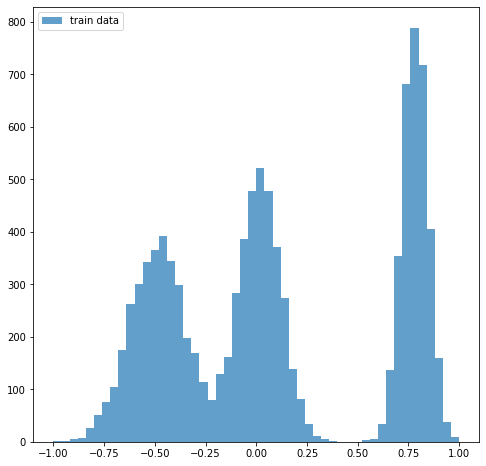

In [6]:
visualize_experiment_dataset(is_spiral=False, modes=n_modes, param_modes=params)

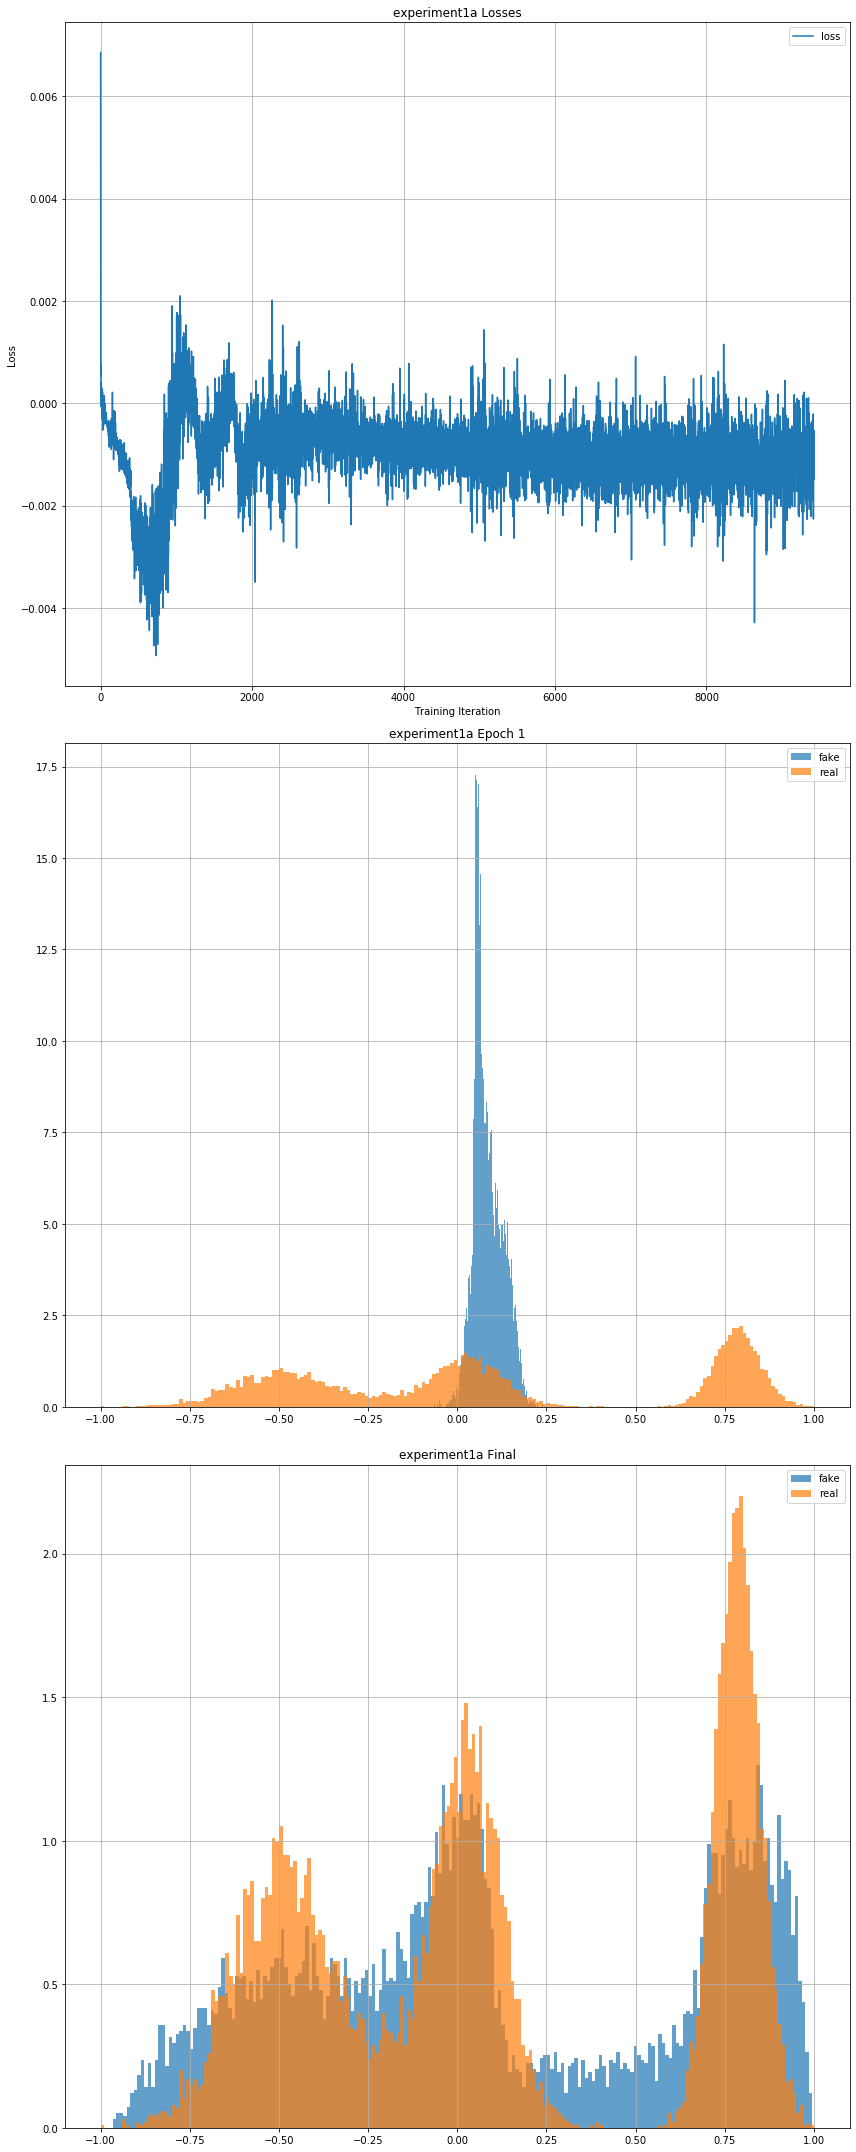

In [7]:
start = time.time()
g, c, train_losses, samples_1, samples_final, pvals = experiment_save_results('a', exp1, "experiment1", 
                                                                              is_spiral=False,
                                                                              modes=n_modes,
                                                                              param_modes=params)
end = time.time()
delta.append(end-start)

> Формула для спирали $r(\theta) = a+b\theta$

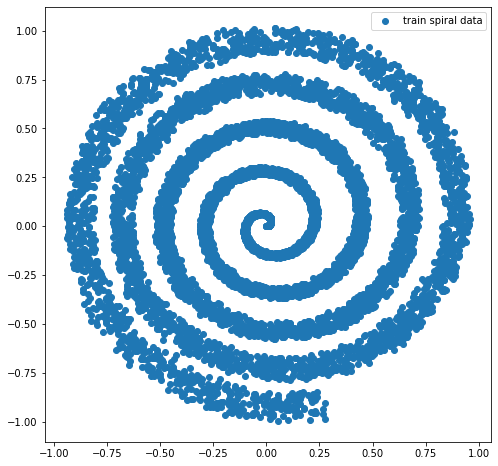

In [9]:
visualize_experiment_dataset(is_spiral=True)

In [10]:
def exp2(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    g = Generator(10, 7, 50, 2).to(ptu.device)
    c = Discriminator(2, 2, 20, 1).to(ptu.device)
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return critic(fake_data).mean() - critic(x).mean() #- 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 50
    c_opt = optim.Adam(c.parameters(), lr=4e-4, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.9))
    c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=10, gamma=0.8)
    g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=10, gamma=0.9)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 2, 
        "final_snapshot":True,
#         "gp_lamb": 1e-1
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=True) #, g_scheduler=g_scheduler, c_scheduler=c_scheduler, is_spiral=True)
    train_losses, samples_1, samples_final, pvals = result
    return g, c, train_losses['c_losses'], samples_1, samples_final, pvals

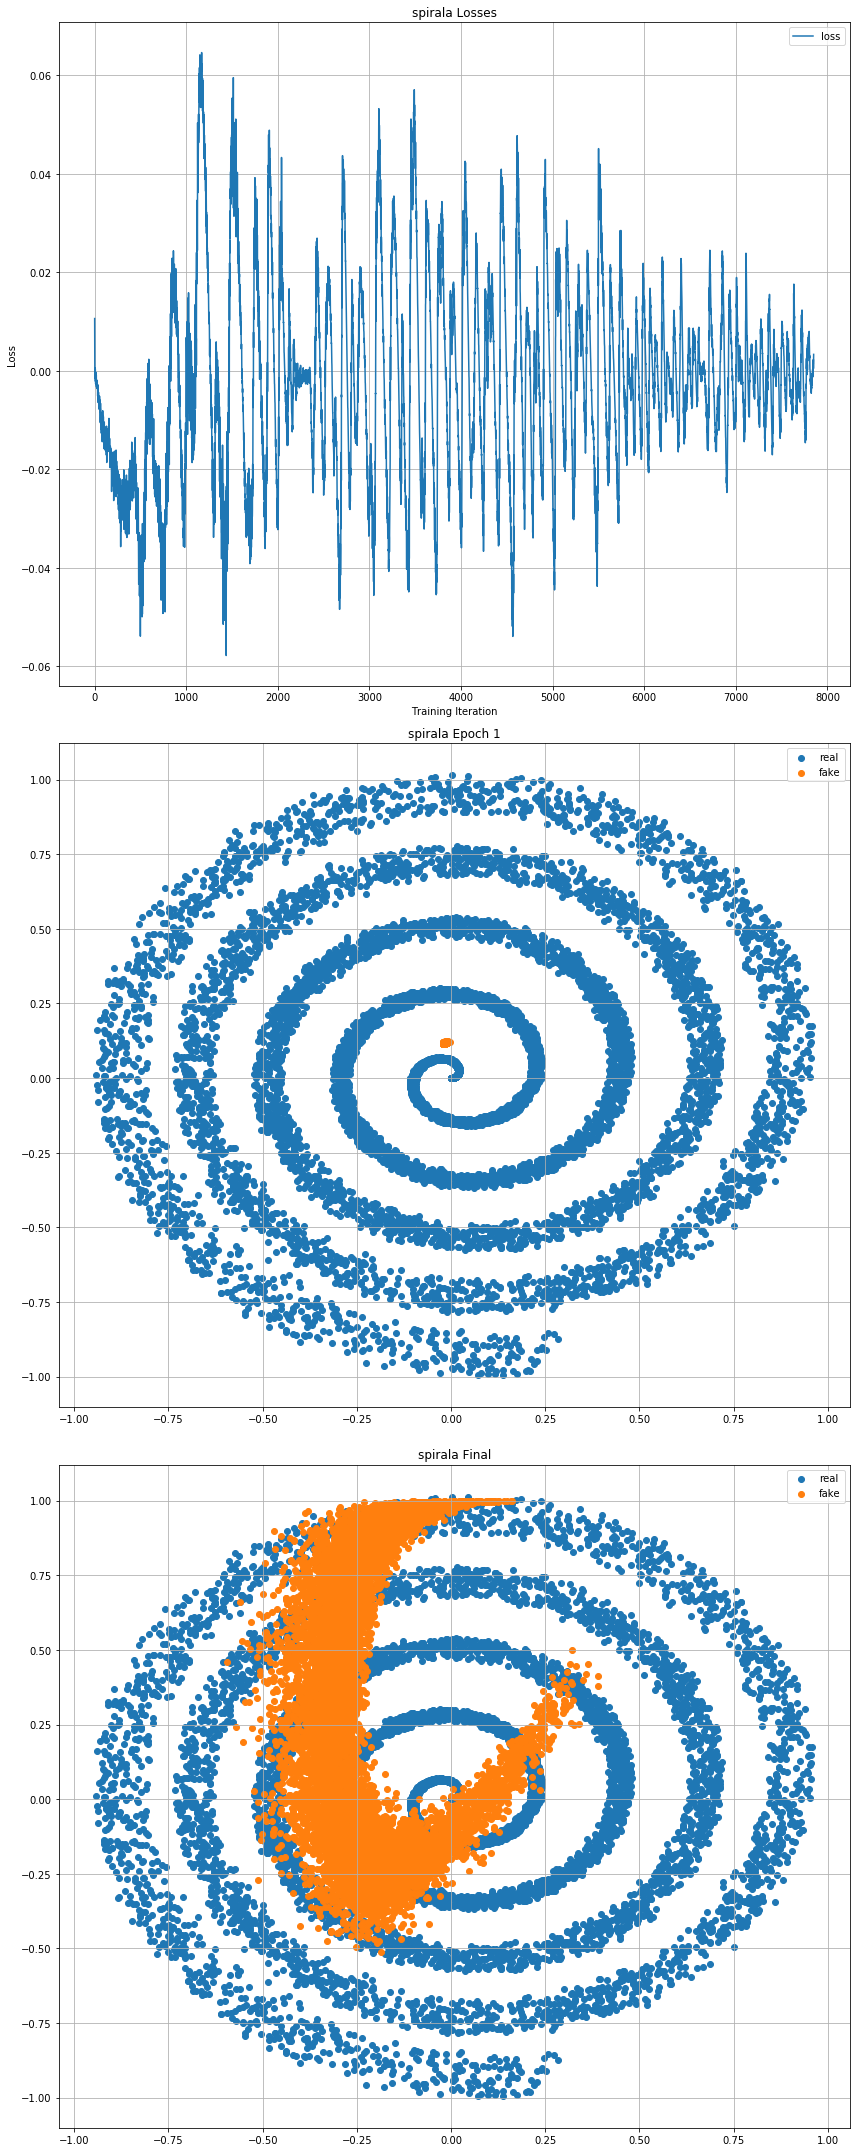

In [11]:
start = time.time()
g, c, *_ = experiment_save_results('a', exp2, 'spiral', is_spiral=True)
end = time.time()
delta.append(end-start)

> 100 epochs, no Spectral Noramlization , $n_cr = 2, t = 183.73s$

> 100 epochs, no Spectral Noramlization , $n_cr = 4, t = 180.28s$

> 100 epochs, no Spectral Noramlization , $n_cr = 4, t = 168.17s$

> 100 epochs, Spectral Noramlization , $n_cr = 2, t = 260.13s$

> 100 epochs, Spectral Noramlization , $n_cr = 4, t = 234.86s$

> 100 epochs, Spectral Noramlization , $n_cr = 6, t = 233.38s$